# Proyek Machine Learning - Prediksi Harga Rumah Pakistan

## Import Library
Melakukan import library yang dibutuhkan untuk keseluruhan proyek.

In [273]:
# Import library
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import math
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.metrics import mean_squared_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.svm import SVR
from scipy.stats import randint
from sklearn.metrics import make_scorer
import warnings
warnings.filterwarnings('ignore')

## Data Loading

Dataset = [Pakistan House Prices - 2023](https://www.kaggle.com/datasets/manjitbaishya001/house-prices-2023)

Dataset diunduh dari Kaggle, Dataset ini memuat informasi mengenai berbagai properti yang tersedia di Pakistan, kemungkinan untuk tujuan jual beli atau sewa. Setiap entri dalam dataset ini tampaknya memiliki ID unik (dari kolom Unnamed: 0) untuk identifikasi. Informasi utama mencakup jenis properti (seperti Flat, House, dll. pada kolom property_type) dan harga yang ditawarkan (price).

Untuk detail lokasi, dataset ini menyediakan informasi mengenai nama area atau sektor spesifik (location) di dalam kota tertentu (city) tempat properti berada. Atribut fisik properti yang dicatat meliputi jumlah kamar mandi (baths) dan jumlah kamar tidur (bedrooms). Selain itu, dataset ini juga mencantumkan tujuan dari iklan properti tersebut, apakah untuk dijual (For Sale) atau disewakan (For Rent) pada kolom purpose. Terakhir, luas properti juga menjadi fitur penting, yang diukur dalam satuan lokal Marla (Area_in_Marla).

In [274]:
# Load csv dari folder data dan tampilkan
df = pd.read_csv('house_prices.csv')

# Cek beberapa baris pertama data
print("Dimensi dataset:", df.shape)
df.head()

Dimensi dataset: (99499, 9)


,Unnamed: 0,property_type,price,location,city,baths,purpose,bedrooms,Area_in_Marla
0,0,Flat,10000000,G-10,Islamabad,2,For Sale,2,4.0
1,1,Flat,6900000,E-11,Islamabad,3,For Sale,3,5.6
2,2,House,16500000,G-15,Islamabad,6,For Sale,5,8.0
3,3,House,43500000,Bani Gala,Islamabad,4,For Sale,4,40.0
4,4,House,7000000,DHA Defence,Islamabad,3,For Sale,3,8.0


### Deskripsi Dataset
Berdasarkan informasi dari sumber dataset, berikut adalah penjelasan untuk masing-masing kolom:

* Unnamed: 0: Kemungkinan adalah indeks atau ID unik yang diberikan untuk setiap baris atau entri properti dalam dataset.
* property_type: Menunjukkan jenis properti yang dijual atau disewakan (misalnya, Flat, House, Upper Portion, Lower Portion, Room, Penthouse, Farm House). Dalam contoh Anda, nilainya adalah "Flat".
* price: Harga properti yang ditawarkan. Dalam contoh pertama, harganya adalah 10.000.000.
* location: Merupakan detail lokasi spesifik atau nama area/sektor dari properti tersebut di dalam kota. Contohnya adalah "G-10" dan "E-11".
* city: Menunjukkan nama kota tempat properti itu berada. Misalnya "Islamabad".
* baths: Jumlah kamar mandi yang ada di properti tersebut.
* purpose: Menunjukkan tujuan dari iklan properti tersebut, apakah "For Sale" (Untuk Dijual) atau "For Rent" (Untuk Disewakan).
* bedrooms: Jumlah kamar tidur yang tersedia di properti.
* Area_in_Marla: Luas properti yang diukur dalam satuan Marla.

## Eksplorasi Data Awal (EDA)
Mari kita lakukan eksplorasi data untuk memahami karakteristiknya:

In [275]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 99499 entries, 0 to 99498
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Unnamed: 0     99499 non-null  int64  
 1   property_type  99499 non-null  object 
 2   price          99499 non-null  int64  
 3   location       99499 non-null  object 
 4   city           99499 non-null  object 
 5   baths          99499 non-null  int64  
 6   purpose        99499 non-null  object 
 7   bedrooms       99499 non-null  int64  
 8   Area_in_Marla  99499 non-null  float64
dtypes: float64(1), int64(4), object(4)
memory usage: 6.8+ MB


In [276]:
df.describe()

,Unnamed: 0,price,baths,bedrooms,Area_in_Marla
count,99499.000000,9.949900e+04,99499.000000,99499.000000,99499.000000
mean,78883.893064,1.037592e+07,3.530106,3.350737,8.757479
std,48239.423663,1.066000e+07,1.474217,1.255913,7.466471
min,0.000000,1.550000e+04,1.000000,0.000000,0.000000
25%,37236.500000,1.500000e+05,2.000000,2.000000,4.800000
50%,76065.000000,7.500000e+06,3.000000,3.000000,6.700000
75%,119401.500000,1.550000e+07,5.000000,4.000000,10.000000
max,168445.000000,4.490000e+07,7.000000,6.000000,194.000000


In [277]:
# Melakukan cek terhadap kolom mana saja yang memiliki value Null
columns_with_nan = df.columns[df.isnull().any()].tolist()

# Membuat DataFrame untuk menampilkan kolom yang memiliki nilai null beserta tipe datanya
nan_info = pd.DataFrame({
    'Tipe Data': df[columns_with_nan].dtypes,
    'Jumlah Null': df[columns_with_nan].isnull().sum()
})

print("Kolom yang memiliki nilai Null beserta tipe datanya:")
print(nan_info)

Kolom yang memiliki nilai Null beserta tipe datanya:
Empty DataFrame
Columns: [Tipe Data, Jumlah Null]
Index: []


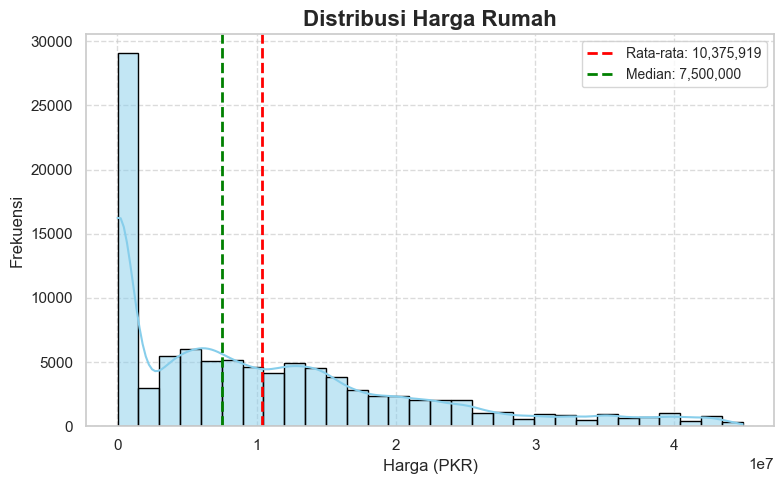

In [278]:
plt.figure(figsize=(8, 5))
sns.set(style="whitegrid")

# Histogram dengan KDE
sns.histplot(df['price'], kde=True, bins=30, color='skyblue', edgecolor='black')

# Judul dan Label
plt.title('Distribusi Harga Rumah', fontsize=16, fontweight='bold')
plt.xlabel('Harga (PKR)', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)

# Garis rata-rata dan median
mean_price = df['price'].mean()
median_price = df['price'].median()
plt.axvline(mean_price, color='red', linestyle='--', linewidth=2, label=f'Rata-rata: {mean_price:,.0f}')
plt.axvline(median_price, color='green', linestyle='--', linewidth=2, label=f'Median: {median_price:,.0f}')

# Tambahkan legenda dan grid
plt.legend(fontsize=10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

In [279]:
# Menampilkan semua kolom yang bertipe data numerik
numeric_columns = df.select_dtypes(include=['number']).columns.tolist()
print("Kolom yang bertipe data numerik:")
print(numeric_columns)

Kolom yang bertipe data numerik:
['Unnamed: 0', 'price', 'baths', 'bedrooms', 'Area_in_Marla']


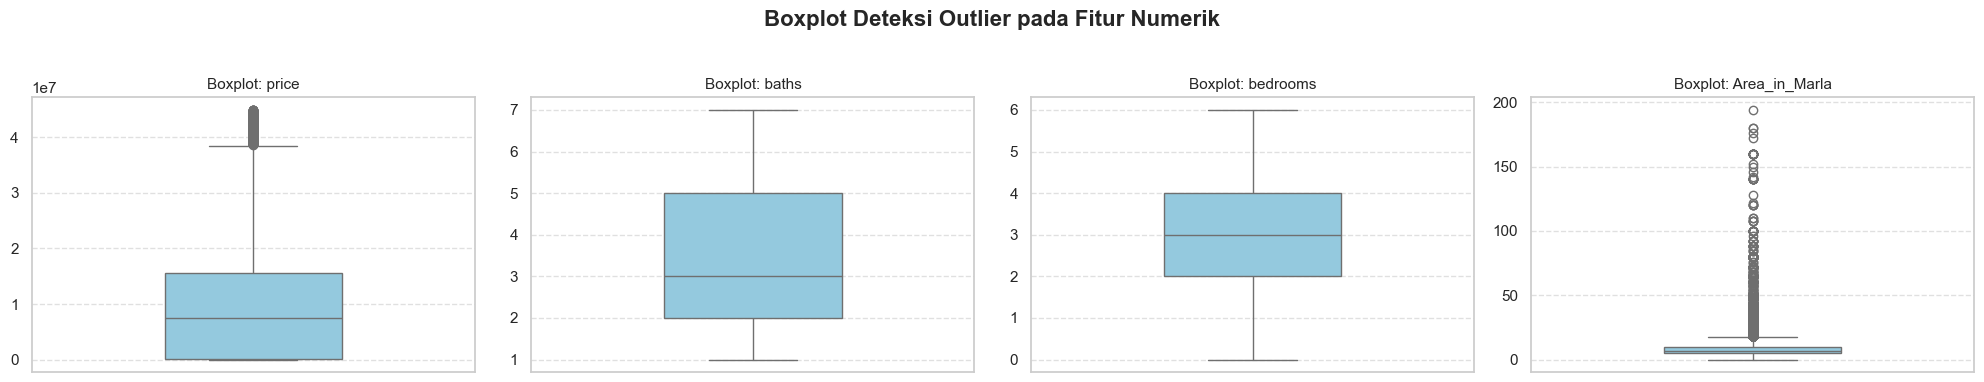

In [280]:
# Kolom numerik untuk dicek outlier
numeric_columns = ['price', 'baths', 'bedrooms', 'Area_in_Marla']

# Ukuran grid subplot dinamis
n_cols = 4
n_rows = math.ceil(len(numeric_columns) / n_cols)

plt.figure(figsize=(20, n_rows * 4))
sns.set(style="whitegrid")

for i, column in enumerate(numeric_columns, 1):
    plt.subplot(n_rows, n_cols, i)
    sns.boxplot(y=df[column], color='skyblue', width=0.4)
    plt.title(f'Boxplot: {column}', fontsize=11)
    plt.ylabel('')
    plt.grid(axis='y', linestyle='--', alpha=0.6)

plt.suptitle('Boxplot Deteksi Outlier pada Fitur Numerik', fontsize=16, fontweight='bold')
plt.tight_layout(rect=[0, 0.03, 1, 0.95])  # memberi ruang untuk suptitle
plt.show()


Output kode di atas memberikan informasi :
* Beberapa fitur numerik yang dianalisis memiliki outliers

In [281]:
#Fungsi untuk menghapus outlier
def remove_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]

#Daftar kolom yang akan diatasi outliersnya
numeric_columns = ['price', 'baths', 'bedrooms', 'Area_in_Marla']

#Menghapus outliers dari masing-masing kolom
for column in numeric_columns:
    df = remove_outliers_iqr(df, column)

# Verifikasi hasil
df.shape

(86464, 9)

Text(0.5, 1.0, 'Correlation Matrix untuk Fitur Numerik ')

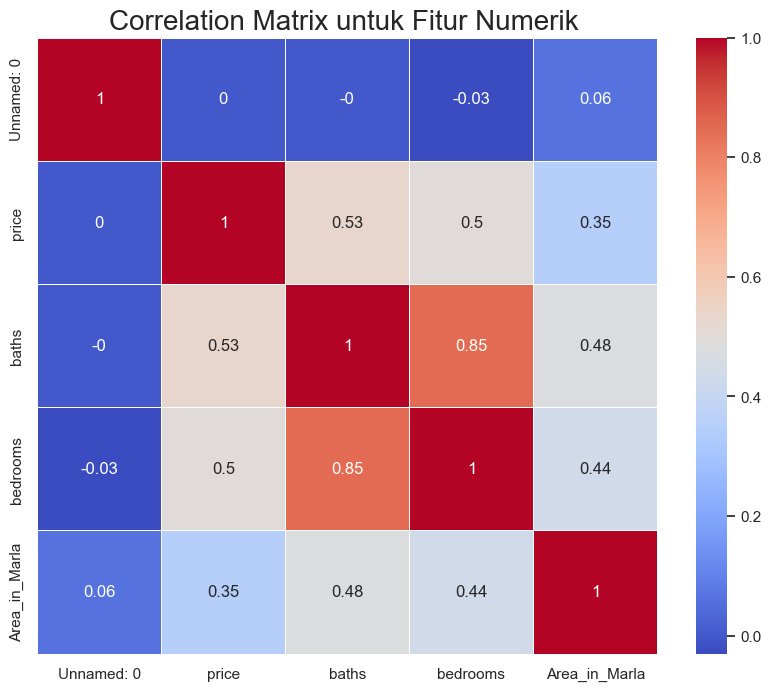

In [282]:
plt.figure(figsize=(10, 8))
numeric_df = df.select_dtypes(include=['float64', 'int64'])
correlation_matrix = numeric_df.corr().round(2)
sns.heatmap(data=correlation_matrix, annot=True, cmap='coolwarm', linewidths=0.5, )
plt.title("Correlation Matrix untuk Fitur Numerik ", size=20)

Dari eksplorasi data di atas, kita dapat menyimpulkan beberapa hal:
1. Dataset berisi 86464 sampel dengan 7 fitur dan 1 target.
2. Tidak terdapat missing values pada dataset.
3. Distribusi harga rumah bersifat right-skewed (skewed to the right / positif skewed).
4. Fitur yang paling kuat korelasinya dengan harga (target) adalah baths (jumlah kamar mandi)
5. Antara baths dan bedrooms memiliki korelasi paling kuat yakni 0.85

## Data Preparation

Pada bagian ini kita akan melakukan persiapan data, yaitu:
* Menghapus fitur yang tidak diperlukan
* Encoding fitur kategori.
* Pembagian data menjadi fitur (X) dan target (y)
* Pembagian data menjadi set pelatihan dan penujian
* Penskalaan fitur numerik

In [283]:
# Menghapus fitur Unnamed 0 karena tidak dibutuhkan
df.drop('Unnamed: 0', axis=1, inplace=True)
df.head(1)

,property_type,price,location,city,baths,purpose,bedrooms,Area_in_Marla
0,Flat,10000000,G-10,Islamabad,2,For Sale,2,4.0


### 1. Encoding

In [284]:
# Frequency Encoding untuk Location
freq_map = df['location'].value_counts()
df['location_encoded'] = df['location'].map(freq_map)
df.drop('location', axis=1, inplace=True)

In [285]:
df.head()

,property_type,price,city,baths,purpose,bedrooms,Area_in_Marla,location_encoded
0,Flat,10000000,Islamabad,2,For Sale,2,4.0,331
1,Flat,6900000,Islamabad,3,For Sale,3,5.6,1592
2,House,16500000,Islamabad,6,For Sale,5,8.0,726
4,House,7000000,Islamabad,3,For Sale,3,8.0,7266
5,Flat,7800000,Islamabad,2,For Sale,2,6.2,1592


In [286]:
# One-Hot Encoding untuk city dan property type
df = pd.get_dummies(df, columns=['city'], drop_first=True)
df = pd.get_dummies(df, columns=['property_type'], drop_first=True)

In [287]:
# Label encoding atau binary coding untuk purpose
df['purpose'] = df['purpose'].map({'For Sale': 1, 'For Rent': 0})

In [288]:
df.head(1)

,price,baths,purpose,bedrooms,Area_in_Marla,location_encoded,city_Islamabad,city_Karachi,city_Lahore,city_Rawalpindi,property_type_Flat,property_type_House,property_type_Lower Portion,property_type_Penthouse,property_type_Room,property_type_Upper Portion
0,10000000,2,1,2,4.0,331,True,False,False,False,True,False,False,False,False,False


In [289]:
#Mengubah nilai True dan False menjadi 1 dan 0
# Ubah hanya kolom boolean ke integer
bool_cols = df.select_dtypes(include='bool').columns
df[bool_cols] = df[bool_cols].astype(int)
df.head(1)

,price,baths,purpose,bedrooms,Area_in_Marla,location_encoded,city_Islamabad,city_Karachi,city_Lahore,city_Rawalpindi,property_type_Flat,property_type_House,property_type_Lower Portion,property_type_Penthouse,property_type_Room,property_type_Upper Portion
0,10000000,2,1,2,4.0,331,1,0,0,0,1,0,0,0,0,0


### 2. Train-Test-Split

In [290]:
# Membagi dataset menjadi fitur dan target. Target merupakan fitur price. Pembagian dataset dengan perbandingan 80:20.
X = df.drop('price', axis=1)
y = df['price']

# Membagi data menjadi set pelatihan dan pengujian
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(f"Ukuran set pelatihan: {X_train.shape[0]} sampel")
print(f"Ukuran set pengujian: {X_test.shape[0]} sampel")

Ukuran set pelatihan: 69171 sampel
Ukuran set pengujian: 17293 sampel


In [291]:
#Melakukan standarisasi terhadap fitur numerik pada data train
numerical_features = ['baths', 'bedrooms', 'Area_in_Marla']
scaler = StandardScaler()
scaler.fit(X_train[numerical_features])
X_train[numerical_features] = scaler.transform(X_train.loc[:, numerical_features])
X_train[numerical_features].head()

,baths,bedrooms,Area_in_Marla
45733,0.458555,-0.172485,1.072243
96959,-0.966269,-1.003680,-1.239381
48522,-0.253857,-0.172485,0.430125
8409,0.458555,1.489905,0.109067
66302,1.170968,2.321101,0.109067


In [292]:
#Melakukan cek terhadap nilai mean dan std
X_train[numerical_features].describe().round(4)

,baths,bedrooms,Area_in_Marla
count,69171.0000,69171.0000,69171.0000
mean,-0.0000,-0.0000,0.0000
std,1.0000,1.0000,1.0000
min,-1.6787,-2.6661,-2.1383
25%,-0.9663,-1.0037,-0.7257
50%,-0.2539,-0.1725,-0.2762
75%,0.4586,0.6587,0.9438
max,2.5958,2.3211,3.5765


Standarisasi berhasil dengan melihat nilai mean = 0 dan std = 1.

**Alasan Penggunaan Teknik Preprocessing:** <br>
- **Train-Test Split:** Untuk mengevaluasi performa model pada data baru yang belum pernah dilihat sebelumnya dan memastikan model dapat melakukan generalisasi dengan baik.<br>
- **StandardScaler:** Menyamakan skala semua fitur agar tidak ada fitur yang mendominasi proses pembelajaran dan penting untuk model yang sensitif terhadap skala fitur (misalnya Regresi Linear, SVR).<br>

## Modeling

Pada bagian ini, kita akan mengembangkan dan mengevaluasi beberapa model untuk memprediksi harga rumah. Sesuai dengan solution statement, kita akan membandingkan performa beberapa algoritma:
1. K-Nearest Neighbor
3. Random Forest
4. Gradient Boosting

In [293]:
#Menyiapkan dataframe untuk analisis masing-masing model
models = pd.DataFrame(index=['train_mse', 'test_mse'],
                      columns=['KNN', 'RF', 'GB'])

In [294]:
#Melatih model KNN
knn_model = KNeighborsRegressor(n_neighbors=10)
knn_model.fit(X_train, y_train)

KNeighborsRegressor(n_neighbors=10)

In [295]:
#Melatih model Random Forest
rf_model = RandomForestRegressor(n_estimators=100, max_depth=16, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(max_depth=16, n_jobs=-1, random_state=42)

In [296]:
#Melatih model Boosting Algorithm
boosting_model = AdaBoostRegressor(learning_rate=0.05, random_state=55)
boosting_model.fit(X_train, y_train)

AdaBoostRegressor(learning_rate=0.05, random_state=55)

### Evaluation

### Metrik Evaluasi yang Digunakan

1. **Mean Squared Error (MSE)** - Rata-rata dari kuadrat selisih antara nilai prediksi dan nilai aktual. MSE memberikan bobot yang lebih besar pada kesalahan yang besar.
   
   $$MSE = \frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2$$

2. **Root Mean Squared Error (RMSE)** - Akar kuadrat dari MSE. RMSE memiliki satuan yang sama dengan variabel target, sehingga lebih mudah diinterpretasi.
   
   $$RMSE = \sqrt{\frac{1}{n} \sum_{i=1}^{n} (y_i - \hat{y}_i)^2}$$

3. **Mean Absolute Error (MAE)** - Rata-rata dari nilai absolut selisih antara nilai prediksi dan nilai aktual. MAE kurang sensitif terhadap outlier dibandingkan MSE/RMSE.
   
   $$MAE = \frac{1}{n} \sum_{i=1}^{n} |y_i - \hat{y}_i|$$

4. **R-squared (R²)** - Proporsi variasi dalam variabel dependen yang dapat dijelaskan oleh variabel independen. Nilai R² berkisar antara 0 dan 1, di mana nilai yang lebih tinggi menunjukkan model yang lebih baik.
   
   $$R^2 = 1 - \frac{\sum_{i=1}^{n} (y_i - \hat{y}_i)^2}{\sum_{i=1}^{n} (y_i - \bar{y})^2}$$

   di mana $\bar{y}$ adalah nilai rata-rata dari $y$.

In [297]:
#Melakukan standarisasi terhadap fitur numerik pada data test
numerical_features = ['baths', 'bedrooms', 'Area_in_Marla']
scaler = StandardScaler()
scaler.fit(X_test[numerical_features])
X_test[numerical_features] = scaler.transform(X_test.loc[:, numerical_features])
X_test[numerical_features].head()

,baths,bedrooms,Area_in_Marla
73908,1.873140,1.473179,1.377650
83994,-0.976531,-1.017194,-0.807238
10626,1.160722,0.643055,1.698957
9125,-0.264113,-0.187070,-0.614454
81316,-0.264113,-0.187070,-0.582323


In [298]:
# Fungsi evaluasi
def evaluate_model(model, X_train, y_train, X_test, y_test, model_name, result_df):
    # Prediksi
    y_train_pred = model.predict(X_train)
    y_test_pred = model.predict(X_test)
    
    # Training metrics
    result_df.loc['train_mse', model_name] = mean_squared_error(y_train, y_train_pred)
    result_df.loc['train_rmse', model_name] = np.sqrt(mean_squared_error(y_train, y_train_pred))
    result_df.loc['train_mae', model_name] = mean_absolute_error(y_train, y_train_pred)
    result_df.loc['train_r2', model_name] = r2_score(y_train, y_train_pred)

    # Testing metrics
    result_df.loc['test_mse', model_name] = mean_squared_error(y_test, y_test_pred)
    result_df.loc['test_rmse', model_name] = np.sqrt(mean_squared_error(y_test, y_test_pred))
    result_df.loc['test_mae', model_name] = mean_absolute_error(y_test, y_test_pred)
    result_df.loc['test_r2', model_name] = r2_score(y_test, y_test_pred)

    return result_df

# Inisialisasi DataFrame kosong
result_df = pd.DataFrame()

result_df = evaluate_model(knn_model, X_train, y_train, X_test, y_test, 'KNN', result_df)
result_df = evaluate_model(rf_model, X_train, y_train, X_test, y_test, 'RF', result_df)
result_df = evaluate_model(boosting_model, X_train, y_train, X_test, y_test, 'Boosting', result_df)

# Tampilkan hasil
print(result_df)


                     KNN            RF      Boosting
train_mse   9.788781e+12  5.890061e+12  2.178827e+13
train_rmse  3.128703e+06  2.426945e+06  4.667791e+06
train_mae   1.808073e+06  1.432871e+06  3.082030e+06
train_r2    8.755708e-01  9.251290e-01  7.230403e-01
test_mse    1.202162e+13  9.391332e+12  2.101028e+13
test_rmse   3.467221e+06  3.064528e+06  4.583697e+06
test_mae    1.994047e+06  1.769583e+06  3.025828e+06
test_r2     8.474768e-01  8.808483e-01  7.334340e-01


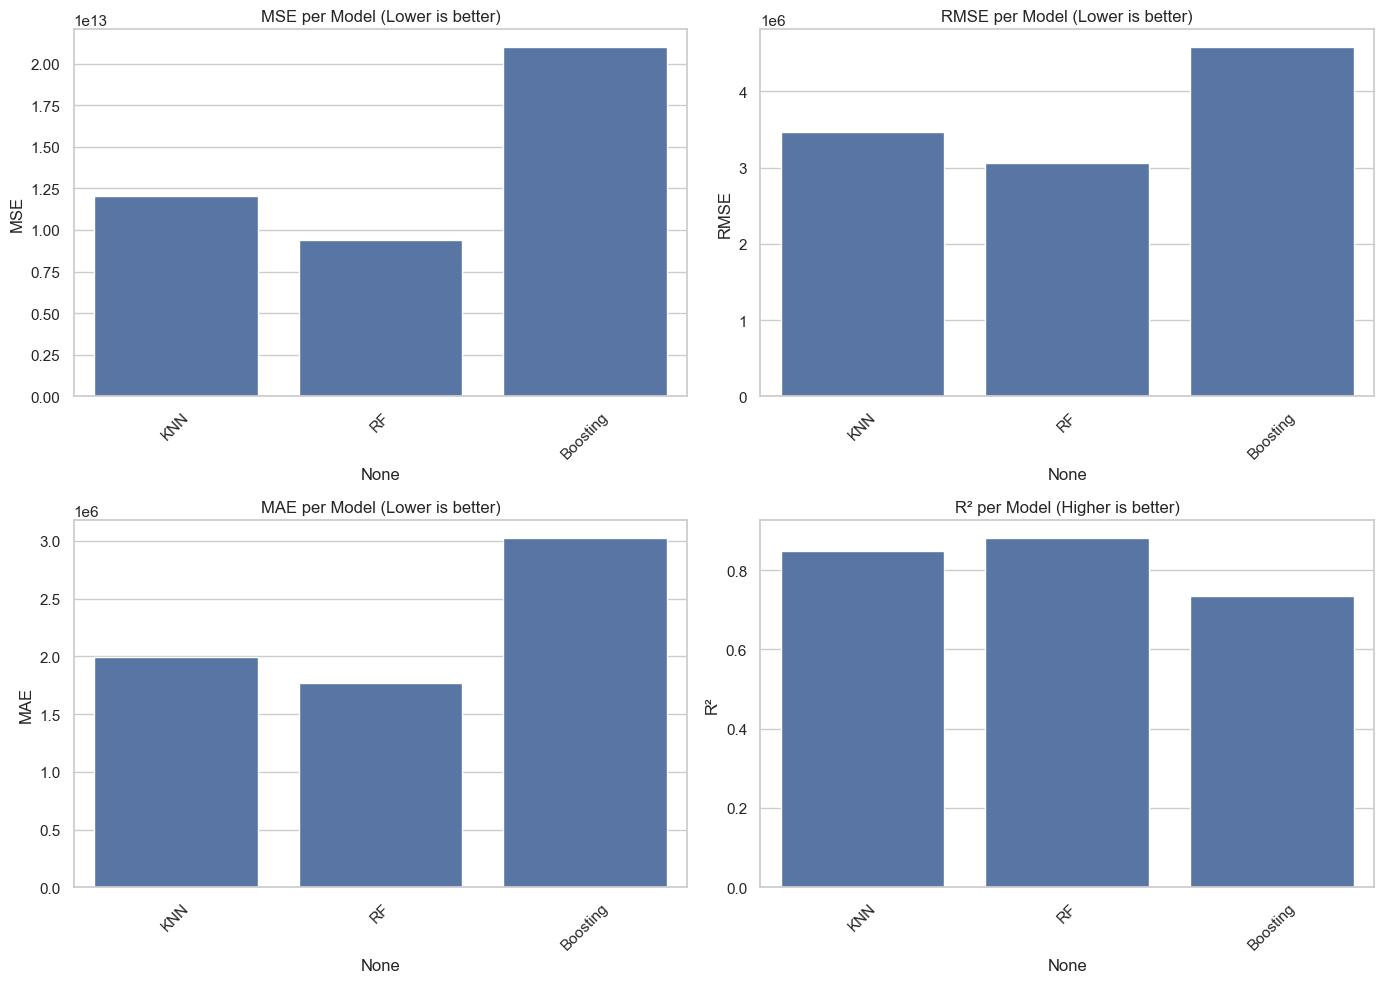

In [299]:
# Visualisasi perbandingan model
plt.figure(figsize=(14, 10))

# MSE (Lower is better)
plt.subplot(2, 2, 1)
sns.barplot(x=results_df.index, y=results_df['MSE'])
plt.title('MSE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('MSE')

# RMSE (Lower is better)
plt.subplot(2, 2, 2)
sns.barplot(x=results_df.index, y=results_df['RMSE'])
plt.title('RMSE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('RMSE')

# MAE (Lower is better)
plt.subplot(2, 2, 3)
sns.barplot(x=results_df.index, y=results_df['MAE'])
plt.title('MAE per Model (Lower is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('MAE')

# R² (Higher is better)
plt.subplot(2, 2, 4)
sns.barplot(x=results_df.index, y=results_df['R²'])
plt.title('R² per Model (Higher is better)', fontsize=12)
plt.xticks(rotation=45)
plt.ylabel('R²')

plt.tight_layout()
plt.show()

In [300]:
#### Melakukan tunning pada RF
# Definisikan parameter grid
param_dist = {
    'n_estimators': randint(50, 300),         # Jumlah pohon
    'max_depth': randint(5, 30),              # Kedalaman maksimal pohon
    'min_samples_split': randint(2, 10),      # Min sampel untuk split internal
    'min_samples_leaf': randint(1, 10),       # Min sampel di daun
    'max_features': ['auto', 'sqrt', 'log2']  # Fitur yang digunakan di tiap split
}

# Inisialisasi model
rf = RandomForestRegressor(random_state=42)

# Setup RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf,
    param_distributions=param_dist,
    n_iter=30,                  # Jumlah kombinasi acak yang dicoba
    cv=3,                       # 3-fold cross-validation
    scoring='neg_mean_squared_error',
    verbose=1,
    n_jobs=-1,
    random_state=42
)

# Jalankan tuning
random_search.fit(X_train, y_train)

# Lihat hasil terbaik
print("Best Parameters:", random_search.best_params_)
print("Best Score (neg MSE):", random_search.best_score_)

# Model terbaik setelah tuning
best_rf_model = random_search.best_estimator_


Fitting 3 folds for each of 30 candidates, totalling 90 fits
Best Parameters: {'max_depth': 26, 'max_features': 'log2', 'min_samples_leaf': 3, 'min_samples_split': 2, 'n_estimators': 276}
Best Score (neg MSE): -9785757211574.107


In [301]:
# Evaluasi dan simpan metrik ke result_df
result_df = evaluate_model(best_rf_model, X_train, y_train, X_test, y_test, 'RF_Tuned', result_df)

rf_before_tuning = result_df['RF']
rf_after_tuning = result_df['RF_Tuned']

# Buat DataFrame perbandingan
comparison = pd.DataFrame({
    'Sebelum Tuning': rf_before_tuning,
    'Setelah Tuning': rf_after_tuning
})

# Cetak hasil
print("Perbandingan performa Random Forest sebelum dan sesudah tuning:")
print(comparison)


Perbandingan performa Random Forest sebelum dan sesudah tuning:
            Sebelum Tuning  Setelah Tuning
train_mse     5.890061e+12    7.702493e+12
train_rmse    2.426945e+06    2.775337e+06
train_mae     1.432871e+06    1.675942e+06
train_r2      9.251290e-01    9.020904e-01
test_mse      9.391332e+12    9.354967e+12
test_rmse     3.064528e+06    3.058589e+06
test_mae      1.769583e+06    1.840509e+06
test_r2       8.808483e-01    8.813097e-01


### Perbandingan Prediksi vs Nilai Aktual

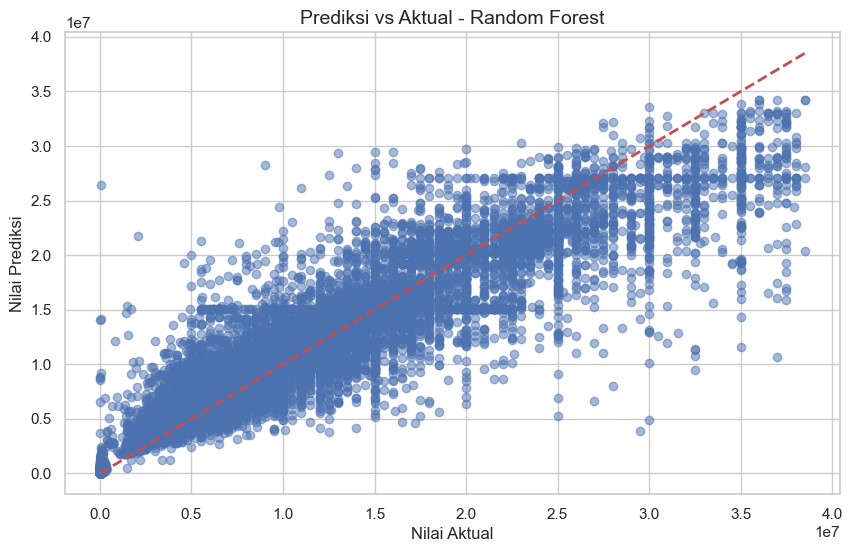

In [302]:
# Prediksi pada data test
y_pred_best = best_rf_model.predict(X_test)

# Visualisasi perbandingan prediksi vs aktual
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_best, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
plt.title('Prediksi vs Aktual - Random Forest', fontsize=14)
plt.xlabel('Nilai Aktual')
plt.ylabel('Nilai Prediksi')
plt.grid(True)
plt.show()

### Menyimpan model

In [215]:
import os
if not os.path.exists('../models'):
    os.makedirs('../models')

# Simpan model terbaik menggunakan joblib
model_path = 'D:/submission-bmlt/models/random_forest_model.pkl'
joblib.dump(best_rf_model, model_path)
print(f"Model berhasil disimpan di {os.path.abspath(model_path)}")

Model berhasil disimpan di D:\submission-bmlt\models\random_forest_model.pkl
